In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
#%%




In [ ]:

from google.colab import drive

drive.mount('/content/gdrive')

folder_path = "/content/gdrive/My Drive/vacances/CAT3"
# Utiliser torchvision.datasets.ImageFolder pour charger les images
# et appliquer des transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


batch_size=64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#%%
train_set = datasets.ImageFolder(root=folder_path, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
#%% Définir la taille du lot (batch size)
batch_size = 64
input_dim=128
kernel_size=4
stride=2
latent_dim=1024



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
batch_size = 64
input_dim=128
kernel_size=4
stride=2
latent_dim=1024

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Conv2d(3,32,kernel_size,stride)
#        self.fc2 = nn.Conv2d(32,64,4,2)
        self.fc21 = nn.Linear(int(((input_dim-kernel_size)/stride+1)**2),latent_dim) # mean
        self.fc22 = nn.Linear(int(((input_dim-kernel_size)/stride+1)**2),latent_dim) # variance
        self.fc3 = nn.Linear(latent_dim,int(((input_dim-kernel_size)/stride+1)**2))
        self.fc4 = nn.ConvTranspose2d(32, 3, kernel_size, stride)

    def encode(self, x):
        h1 = F.sigmoid(self.fc1(x))
        # h1 = h1.view()
        h1 = h1.view(h1.size(0),h1.size(1),1,-1)
        return self.fc21(h1), self.fc22(h1) # returns mean and variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # returns sampled latent variable z

    def decode(self, z):
#        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z)) # returns reconstructed image

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0),z.size(1),int((input_dim-kernel_size)/stride+1),int((input_dim-kernel_size)/stride+1))
        return self.decode(z), mu, logvar





In [ ]:
def loss_function(x,recon_x , mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#%%

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        u=0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)

            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()
            if u%5000==0:
                print(batch_idx/len(train_loader), overall_loss)
            loss.backward()
            optimizer.step()

        print("Epoch", epoch + 1, "Average Loss:", overall_loss / (batch_idx * batch_size))
    return overall_loss
#%%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#%%
train(model, optimizer, epochs=2,device=device)
#%%


0.0 2389795.0
0.008620689655172414 10642356.0
0.017241379310344827 13322442.5
0.02586206896551724 16583208.0
0.034482758620689655 21394563.0
0.04310344827586207 25732731.5
0.05172413793103448 29136028.0
0.0603448275862069 32277197.25
0.06896551724137931 35819071.25
0.07758620689655173 39677508.5
0.08620689655172414 43310586.5
0.09482758620689655 46406173.0
0.10344827586206896 49074301.75
0.11206896551724138 51597617.0
0.1206896551724138 54210665.25
0.12931034482758622 56976232.75
0.13793103448275862 59696001.0
0.14655172413793102 62255051.75
0.15517241379310345 64716735.25
0.16379310344827586 67150048.25
0.1724137931034483 69619992.75
0.1810344827586207 72116357.75
0.1896551724137931 74587380.25
0.19827586206896552 76974593.5
0.20689655172413793 79293765.5
0.21551724137931033 81590947.0
0.22413793103448276 83905930.75
0.23275862068965517 86264487.25
0.2413793103448276 88643647.75
0.25 90979146.0
0.25862068965517243 93268629.75
0.2672413793103448 95528778.75
0.27586206896551724 97768625

241681215.5

In [ ]:
train(model, optimizer, epochs=100,device=device)
file_path = folder_path = "/content/gdrive/My Drive/vacances/vae_114ep.pt"
torch.save(model, file_path)

0.0 1735119.875
0.008620689655172414 3504571.875
0.017241379310344827 5242316.625
0.02586206896551724 7008825.375
0.034482758620689655 8811186.375
0.04310344827586207 10597716.375
0.05172413793103448 12397239.125
0.0603448275862069 14221627.625
0.06896551724137931 15979907.0
0.07758620689655173 17756652.25
0.08620689655172414 19557459.0
0.09482758620689655 21309894.875
0.10344827586206896 23075787.125
0.11206896551724138 24801941.5
0.1206896551724138 26538261.25
0.12931034482758622 28328981.375
0.13793103448275862 30119647.125
0.14655172413793102 31920942.0
0.15517241379310345 33714916.25
0.16379310344827586 35478410.375
0.1724137931034483 37285866.125
0.1810344827586207 39064927.0
0.1896551724137931 40849060.0
0.19827586206896552 42601626.5
0.20689655172413793 44363808.25
0.21551724137931033 46147561.25
0.22413793103448276 47942100.5
0.23275862068965517 49772387.25
0.2413793103448276 51551098.75
0.25 53335812.75
0.25862068965517243 55071708.25
0.2672413793103448 56883331.875
0.2758620

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


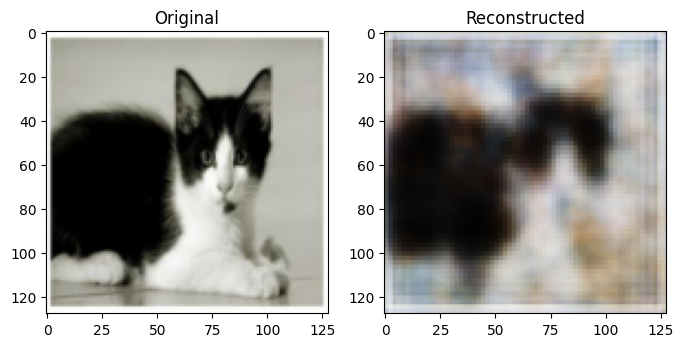

In [ ]:
# convert the tensors to numpy arrays and reshape them into images
import random
image,_ = train_set.__getitem__(random.randint(0,100))
with torch.no_grad():
    image = image.to(device)
    print(image.size())
    recon_image, mu, logvar = model(image.unsqueeze(0))
    print(recon_image.size())
image =image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))

recon_image = recon_image.cpu().numpy()[0]
recon_image = np.transpose(recon_image, (1, 2, 0))

# display the original image and the reconstructed image side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(recon_image)
axes[1].set_title("Reconstructed")
plt.show()
#%% test visuel
